In [2]:
#import libraries for manipulating data
import numpy as np
import pandas as pd

#importing library for stats
import scipy.stats as st

#import libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#import data set
train = pd.read_csv("data/Train.csv")

# Problem context

Logistics in Sub-Saharan Africa increases the cost of manufactured goods by up to 320%; while in Europe, 
it only accounts for up to 90% of the manufacturing cost. The aim of this hackathon is to help Sendy predict
delivery time from driver picking up the item to the time of delivery. This will help Sendy to enhance 
customer communication, reliability, and customer experience in general. In addition, the solution will 
enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved
resource management and planning for order scheduling.


# Exploratory Data Analysis (EDA)

In [4]:
train.shape

(21201, 29)

In [5]:
train.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival'],
      dtype='object')

In [6]:
train.head(5)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [8]:
riders = pd.read_csv("data/Riders.csv")
riders

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156
...,...,...,...,...,...
955,Rider_Id_896,152,99,12.4,18
956,Rider_Id_149,69,101,10.2,10
957,Rider_Id_270,338,96,14.4,41
958,Rider_Id_201,159,96,15.0,9


# Feature Engineering

In [9]:
def remove_colon(number):
    if number[-1]==':' or number[-1]=='A' or number[-1]=='P' :
        number = number[:-1]
        
    return number

def convert_dates_to_seconds(df, date="Pickup - Day of Month",
                              time="Pickup - Time"):
    """takes in pandas dataframe and converts time stamps
    into seconds """
    date_in_seconds = []
    days_in_seconds = (df[date]-1)*3600*24
    
    for i in range(len(df)):
        hours = int(remove_colon(df[time][i][:2]))
        mins =  int(remove_colon(df[time][i][3:5]))
        seconds =  int(remove_colon(df[time][i][6:9]))
        
        if df[time][i][-2:] =='PM':
            date_in_seconds.append((hours+12)*3600+mins*60+seconds)
            
        else:
            date_in_seconds.append((hours)*3600+mins*60+seconds)
                
        
    
    return date_in_seconds

In [10]:
def correct_data_format(df):
    df = df.copy()
    """takes in data frame and transforms it into preferred data frame """
    
    #convert dates
    df["Placement - Time"] = convert_dates_to_seconds(df,date= "Placement - Day of Month",time ="Placement - Time")
    df["Confirmation - Time"] = convert_dates_to_seconds(df,date= "Confirmation - Day of Month",time ="Confirmation - Time")
    df["Pickup - Time"] = convert_dates_to_seconds(df,date= "Pickup - Day of Month",time ="Pickup - Time")
    df["Arrival at Pickup - Time"] = convert_dates_to_seconds(df,date= "Arrival at Pickup - Day of Month",time ="Arrival at Pickup - Time")
    #drop columns
    df.drop(["Placement - Day of Month","Confirmation - Day of Month", "Precipitation in millimeters",
             "Pickup - Day of Month","Arrival at Destination - Day of Month",
            "Arrival at Destination - Time","Order No","User Id"],axis=1,inplace=True)

    
    
    return df

In [12]:
train = correct_data_format(train)

In [13]:
train = pd.merge(train,riders,on="Rider Id")

# Visualizations

Text(0.5, 0, 'Platform type')

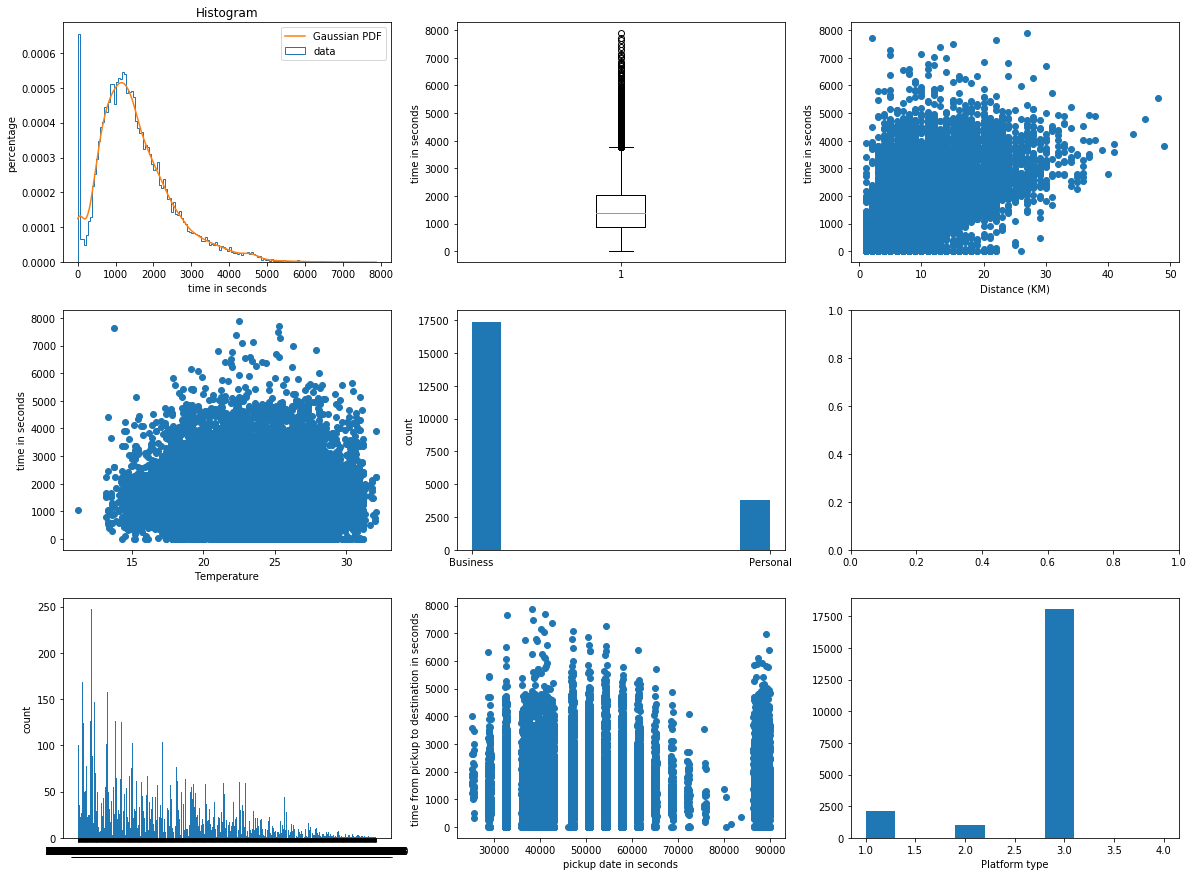

In [16]:
fig, ((ax1, ax2, ax3), (ax4, ax5 ,ax6),(ax7, ax8,ax9)) = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False,figsize = (20,15))


ax1.hist(train["Time from Pickup to Arrival"], 150, histtype = 'step',density = True, label = "data");


kde_xs = np.linspace(0, train["Time from Pickup to Arrival"].max(), 301)
kde = st.gaussian_kde(train["Time from Pickup to Arrival"])
ax1.plot(kde_xs, kde.pdf(kde_xs), label="Gaussian PDF")
ax1.legend(loc="upper right")
ax1.set_xlabel("time in seconds")
ax1.set_ylabel("percentage");
ax1.set_title("Histogram");


ax2.boxplot(x=train["Time from Pickup to Arrival"])
ax2.set_ylabel("time in seconds");

ax3.scatter(train["Distance (KM)"],train["Time from Pickup to Arrival"])
ax3.set_xlabel("Distance (KM)")
ax3.set_ylabel("time in seconds")

ax4.scatter(train["Temperature"],train["Time from Pickup to Arrival"])
ax4.set_xlabel("Temperature")
ax4.set_ylabel("time in seconds")

ax5.hist(train["Personal or Business"])
ax5.set_ylabel("count")

#ax6.hist(train["Vehicle Type"])
#ax6.set_ylabel("count")

ax7.hist(train["Rider Id"], bins=960)
ax7.set_ylabel("count")

ax8.scatter(train["Pickup - Time"],train["Time from Pickup to Arrival"])
ax8.set_xlabel("pickup date in seconds")
ax8.set_ylabel("time from pickup to destination in seconds")

ax9.hist(train["Platform Type"], bins = 10)
ax9.set_xlabel("Platform type")

This dataset appears to have a normal distribution. This implies that we can use gaussian statistics to analyze the distribution of this data set with confidence. The worrying factor in the distribution is that the tails runs for a long time.

The box plot is skewed to the right. This means that quicker delivery times are closer to each other and deliveries that take time are not as close each other.

# Test Data

In [21]:
test = pd.read_csv("data/Train.csv")

In [22]:
test = correct_data_format(test)
test = pd.merge(test,riders,on="Rider Id")

In [23]:
test

,Vehicle Type,Platform Type,Personal or Business,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Bike,3,Business,5,32706,5,32400,9,5,36287,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Bike,3,Personal,5,54067,5,54060,18,5,58026,...,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549
2,Bike,3,Business,5,89501,5,46929,31,5,46802,...,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549
3,Bike,3,Personal,2,25320,2,25329,2,2,25504,...,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549
4,Bike,2,Personal,2,38458,2,38544,22,2,39360,...,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21196,Bike,3,Business,2,40177,2,41538,13,2,42572,...,-1.265003,36.812624,-1.265432,36.795034,Rider_Id_528,919,5770,1793,14.2,2205
21197,Bike,3,Personal,4,57787,4,58027,21,4,57781,...,-1.269609,36.825741,-1.278067,36.783487,Rider_Id_638,2331,102,873,13.7,32
21198,Bike,3,Business,1,61200,1,61261,10,1,64864,...,-1.250823,36.789526,-1.285850,36.830629,Rider_Id_773,2418,5,105,0.0,0
21199,Bike,3,Business,2,50465,2,50523,29,2,50705,...,-1.291787,36.787267,-1.298575,36.808800,Rider_Id_860,717,5,448,15.0,2


# fitting simple linear against distance

In [78]:
x_train = dataset.iloc[:,20:21].values

y_train = dataset["Time from Pickup to Arrival"].values

In [80]:
#fit the multiple linear regression to the training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Text(0, 0.5, 'time in seconds')

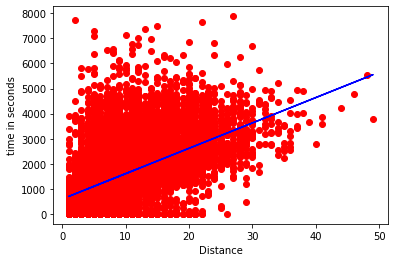

In [82]:
plt.scatter(x_train,y_train,color = 'r')
plt.plot(x_train, regressor.predict(x_train),color = 'b')
plt.xlabel("Distance")
plt.ylabel("time in seconds")

In [83]:
#build the polynomial regression model
from sklearn.preprocessing import PolynomialFeatures
polynomial_regressor = PolynomialFeatures(degree = 4)
x_poly = polynomial_regressor.fit_transform(x_train)
linear_regressor2 = LinearRegression()
linear_regressor2.fit(x_poly,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Text(0, 0.5, 'time in seconds')

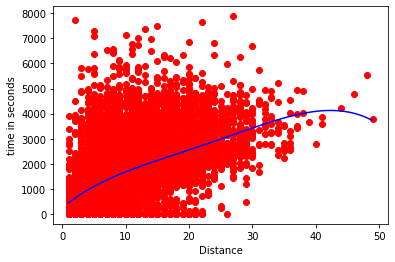

In [89]:
#visualize the polynomial results

x_grid = np.arange(min(x_train),max(x_train),0.1)
x_grid = x_grid.reshape((len(x_grid),1))

plt.scatter(x_train,y_train,color='r')
plt.plot(x_grid,linear_regressor2.predict(polynomial_regressor.fit_transform(x_grid)),color = 'b')
plt.xlabel("Distance")
plt.ylabel("time in seconds")

In [91]:
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf')
regressor_svr.fit(x_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

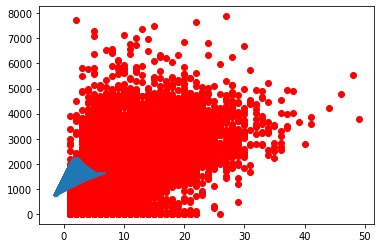

In [92]:
#visualize SVR 
plt.scatter(x_train,y_train,color = 'r')
plt.plot(x,regressor_svr.predict(x_train))

Text(0.5, 0.5, 'right')

<Figure size 432x432 with 0 Axes>

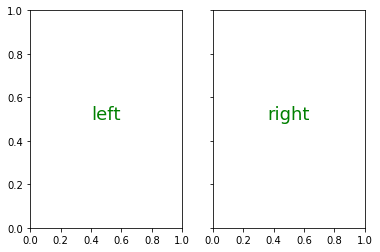

In [95]:
plt.figure(figsize=(6, 6))

fig, (ax1, ax2)  = plt.subplots(1, 2,
                                sharey='row')

ax1.text(0.5, 0.5, 
              "left",
              color="green",
              fontsize=18, 
              ha='center')

ax2.text(0.5, 0.5, 
              "right",
              color="green",
              fontsize=18, 
              ha='center')

AttributeError: 'DataFrame' object has no attribute 'Distance'